In [11]:
# Cell 1 : From scratch implemenattion of Agglomerative clustering model with single linkage.

# Contents:
# 1. Pre-processing
# 2. Scratch Implementation
# 3. Results with graphs

In [3]:
# Read me
# Please run the code twice if you are unable to see the graph at the end.
# Make sure data set is in the same folder as the .ipyb file 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 541 samples in 0.000s...
[t-SNE] Computed neighbors for 541 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 541 / 541
[t-SNE] Mean sigma: 19.730175
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.562519
[t-SNE] KL divergence after 3150 iterations: 0.219853
('Tuned Silhouette Score: ', [0.6293544, 0.6293544, 0.6293544])
('Tuned NMI and Silhouette Score: ', [0.39292912110588435, 0.39292912110588435, 0.39292912110588435])


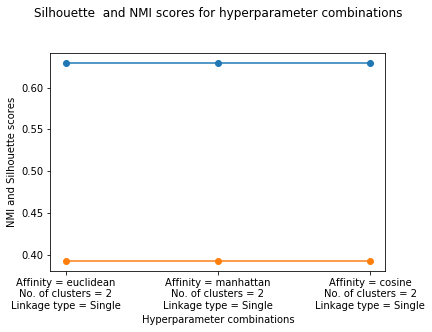

In [4]:
#import statements
import random
import sys
import math
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from subprocess import check_output
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
from sklearn.model_selection import GridSearchCV

# 1. Pre-processing

#Removing outliers using Z-Score
def remove_outliers(data, column, threshold=3):
    mean = np.mean(data[column])
    std = np.std(data[column])
    
    z_scores = (data[column] - mean) / std
    data = data[np.abs(z_scores) < threshold]
    
    return data

#Load dataset from csv file
df = pd.read_csv('Path to the data set')

#Drop the column id and the Unnamed: 32 since they obviously add no value to our analysis
df = df.drop('id',axis=1)
df = df.drop('Unnamed: 32',axis=1)

#Encode the target column as M = 0 and B = 1 since it would be cleaner to compare preditions
#and results as numbers for clustering algorithms
df['diagnosis'] = df['diagnosis'].map({'M':0,'B':1})

#LASSO feature selection
from sklearn.linear_model import Lasso
A, b = df.drop(['diagnosis'], axis=1).values, df['diagnosis'].values
# fit Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(A, b)

# print selected features
drop_features = []
for feature, coef in zip(df.drop(['diagnosis'], axis=1).columns, lasso.coef_):
    if coef == 0:
        drop_features.append(feature)
df = df.drop(columns=drop_features)

#Removing outliers for each column using Z-Score
for column in df.columns:
    df = remove_outliers(df, column)

#Converting the dataframes to numpy arrays to pass as input to our functions
X = df.drop(['diagnosis'], axis=1).values
y = df['diagnosis'].values

#t-SNE method for dimentionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=40, n_iter= 4000, n_components = 2)
X = tsne.fit_transform(X)

# 2. Scratch Implementation

#Function to return the Euclidean distance between two points
def euclidean_dist(x1, y1, x2, y2):
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

#Function to return the Cosine distance between two points
def cosine_dist(x1, y1, x2, y2):
    x = np.array([x1, y1])
    y = np.array([x2, y2])
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    return 1.0 - (dot_product / (norm_x * norm_y))
    return distance

#Function to return the Manhattan Distance between two points
def manhattan_dist(x1, y1, x2, y2):
    distance = abs(x2 - x1) + abs(y2 - y1)
    return distance

#Returns the distance matrix based on the selected distance funtion for the input numpy array
def distance(X, distance_func):
    ans = []
    if(distance_func == 'euclidean'):
        for i in range(0, len(X)):
            dist_x = []
            for j in range(0, len(X)):
                dist_x.append(euclidean_dist(X[i][0], X[i][1], X[j][0], X[j][1]))
            ans.append(dist_x)
    elif(distance_func == 'manhattan'):
        for i in range(0, len(X)):
            dist_x = []
            for j in range(0, len(X)):
                dist_x.append(manhattan_dist(X[i][0], X[i][1], X[j][0], X[j][1]))
            ans.append(dist_x)
    else:
        for i in range(0, len(X)):
            dist_x = []
            for j in range(0, len(X)):
                dist_x.append(cosine_dist(X[i][0], X[i][1], X[j][0], X[j][1]))
            ans.append(dist_x)
    return ans

#My agglomerative function takes only 3 inputs as shown below
def fit_agg_scratch(X, n_clusters, distance_func='euclidean'):
    dist_mat = distance(X, distance_func)
    cluster_num = len(X)
    clusters = {}
    #Using a dictionary I'm initially keeping each data point as a cluster. Conerting the input numpy array to list
    for i in range(0,len(X)):
        val = []
        val.append(list(X[i]))
        val[0].append(i)
        clusters[i] = val
    #Running a while loop until number of clusters is greater than the final number of clusters needed.
    while(cluster_num > n_clusters):
        #In each ittreation we need the find the pair of clusters with minimum distance from each other.
        min_dist = sys.maxsize
        c1 = -1
        c2 = -1
        for i in clusters.keys():
            for j in clusters.keys():
                if(i != j):
                    #The distance between the two clusters would be the updated value in the matrix
                    dist = dist_mat[clusters.get(i)[0][2]][clusters.get(j)[0][2]]
                    #Keeping track of the clusters with the least distance
                    if (min_dist > dist):
                        min_dist = dist
                        c1 = i
                        c2 = j
        #After finding the two clusters, I am trying to pop on of the cluster's key value pair 
        #and add the value to another cluster making then one.
        val2 = clusters.pop(c2)
        val1 = clusters.get(c1)
        for i in val2:
            val1.append(i)
        clusters.update({c1:val1})
        #After merginng there is one less cluster.
        cluster_num -= 1
        #After merging two clusters, we need to update the distances of each of the other clusters so that 
        #the distance matrix shows the shortest distance from any point in one cluster to any point on another cluster.
        for i in range(0, len(X)):
            min = sys.maxsize
            for j in clusters.get(c1):
                if min > dist_mat[i][j[2]]:
                    min = dist_mat[i][j[2]]
            for j in clusters.get(c1):
                dist_mat[i][j[2]] = min
                dist_mat[j[2]][i] = min
    #The ans returned contains the list of each data point correspondingly assigned to either 1 or 0 depending on
    #which cluster they are in.
    ans = []
    for i in range(0, len(X)):
        ans.append(1)
    for i in clusters.get(clusters.keys()[0]):
        ans[i[2]] = 0
    return ans

#Tuning the distance function for better results
affinities = ['euclidean', 'manhattan', 'cosine']
tuning_sill_score = []
tuning_nmi_score = []

#Looping through each of the distance function.
for affinity in affinities:
    #Predicting using my from scratch model
    y_pred2 = np.array(fit_agg_scratch(X, 2, affinity))
    
    tuning_sill_score.append(silhouette_score(X, y_pred2)) #Silhouette Score
    tuning_nmi_score.append(normalized_mutual_info_score(y, y_pred2)) #NMI Score

# 3. Results with graphs    

# Printing the results
print("Tuned Silhouette Score: ", tuning_sill_score)
print("Tuned NMI and Silhouette Score: ", tuning_nmi_score)

#Plotting the results
hyper_parameter = ["Affinity = euclidean\nNo. of clusters = 2\nLinkage type = Single", "Affinity = manhattan\nNo. of clusters = 2\nLinkage type = Single", "Affinity = cosine\nNo. of clusters = 2\nLinkage type = Single"]
plt.plot(hyper_parameter, tuning_sill_score, marker='o')

plt.title('Silhouette  and NMI scores for hyperparameter combinations\n\n')
plt.xlabel('Hyperparameter combinations')

hyper_parameter = ["Affinity = euclidean\nNo. of clusters = 2\nLinkage type = Single", "Affinity = manhattan\nNo. of clusters = 2\nLinkage type = Single", "Affinity = cosine\nNo. of clusters = 2\nLinkage type = Single"]
plt2.plot(hyper_parameter, tuning_nmi_score, marker='o')

plt2.ylabel('NMI and Silhouette scores')

plt2.show()
plt.show()